# SARAH LIU, Homework #1
BMCS 4480: Statistical Machine Learning for Genomics 
Spring 2024

Collaborated with William Specht

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
import scanpy as sc
import anndata as ad

## 1a.

In [3]:
barcodes_fn = 'barcodes.tsv'
genes_fn = 'genes.tsv'
matrix_fn = 'matrix.mtx'

# read the tsv files holding the barcode and gene names
barcodes = pd.read_csv(barcodes_fn, header=None, sep='\t')
genes = pd.read_csv(genes_fn, header=None, sep="\t")

In [4]:
# Construct bacodes x genes numpy array to hold dense matrix from matrix.mtx file
data = np.zeros((len(barcodes), len(genes)))

with open("matrix.mtx") as f:
    for i in range(3):
        f.readline()
    for row in f:
        gene, barcode, count = row.split(" ")
        data[int(barcode)-1, int(gene)-1] = int(count)

In [5]:
# shape of the matrix:
data.shape

(4340, 33694)

There are 4340 different cells and 33694 different genes.

## 1b.

Text(0, 0.5, 'Number of Cells')

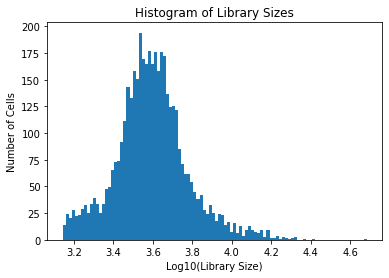

In [41]:
# Summing and plotting total gene expression counts per cell
cell_counts = np.sum(data, axis=1)

plt.hist(np.log10(cell_counts), bins=100)

plt.title('Histogram of Library Sizes')
plt.xlabel("Log10(Library Size)")
plt.ylabel("Number of Cells")

Histogram distribution is vaguely log normal. Needs small amount of filtering to filter out what are likely empty cell droplets.

In [78]:
# Filter out empty droplets so that distribution is log normal
filter_cell_counts = np.log10(cell_counts) > 3.27
filtered_cell_counts = data[filter_cell_counts, :]

filtered_barcodes = barcodes[filter_cell_counts]

Text(0, 0.5, 'Number of Cells')

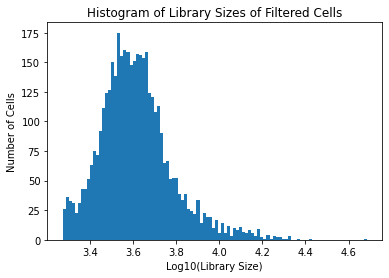

In [88]:
# Plotting filtered total counts per cell 
plt.hist(np.log10(np.sum(filtered_cell_counts, axis=1)), bins=100)

plt.title('Histogram of Library Sizes of Filtered Cells')
plt.xlabel("Log10(Library Size)")
plt.ylabel("Number of Cells")

In [80]:
# Computing median library size after filtering cells
np.median(np.sum(filtered_cell_counts, axis=1))

3960.5

Median library size is 3960.5 genes

# 1c.

Text(0.5, 0, 'Log10(Number of Cell Expressions)')

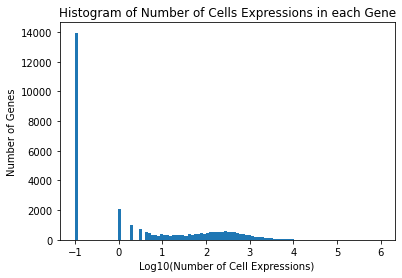

In [89]:
# Plotting number of cells expressing each gene
gene_counts = np.sum(filtered_cell_counts[:,:], axis=0)+.1

plt.hist(np.log10(gene_counts), bins=100)

plt.title("Histogram of Number of Cells Expressions in each Gene")
plt.ylabel("Number of Genes")
plt.xlabel("Log10(Number of Cell Expressions)")

Distribution is bimodal. Large mode on the left is the noisy genes.

In [82]:
# Filtering lower mode as noisy genes
filter_gene_counts = np.log10(gene_counts) > 1.3

filtered_counts = filtered_cell_counts[:,filter_gene_counts]

filtered_genes = genes[filter_gene_counts]
len(filtered_genes)

12398

12398 of the original 33694 genes remain after filtering out the noisy genes.

Text(0.5, 0, 'Log10(Number of Cell Expressions)')

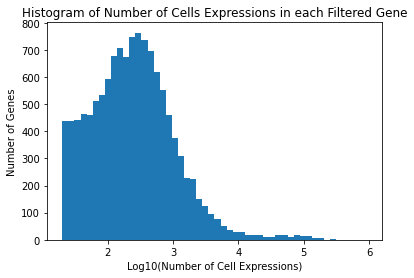

In [90]:
plt.hist(np.log10(np.sum(filtered_counts, axis=0)), bins=50)

plt.title("Histogram of Number of Cells Expressions in each Filtered Gene")
plt.ylabel("Number of Genes")
plt.xlabel("Log10(Number of Cell Expressions)")

# 2a.

In [94]:
# Normalizing data, scaling to median library size
library_sizes = np.sum(filtered_counts, axis=1)

median_lib_size = np.median(library_sizes)
normalize_lib_size = np.array([median_lib_size / np.sum(filtered_counts, axis=1)])

In [97]:
# Scaling each expression count
norm_counts = filtered_counts * normalize_lib_size.T
norm_counts.shape

(4138, 12398)

# 2b.

In [98]:
# Embedding the normalized data to 2D using UMAP
adata = ad.AnnData(norm_counts)

adata.var_names = filtered_genes[1]
adata.obs_names = filtered_barcodes.values[:,0]

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/sarahmialiu/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


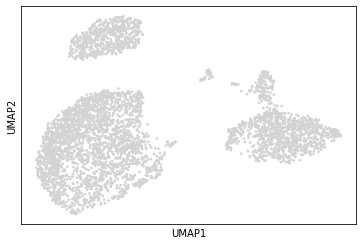

In [100]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata)

In [99]:
adata.shape

(4138, 12398)

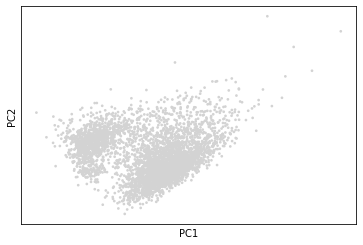

In [101]:
# Displaying first two principal components
sc.pl.pca(adata)

Using principal component analysis assumes a linear relationship between features and is sensitive to outliers in the data. Additionally, PCA assumes that the two most important components are orthogonal and that variability is the most important.

# 2c.

In [104]:
# Adding library sizes to obs
adata.obs["Library Size"] = np.log10(np.sum(filtered_counts, axis=1))

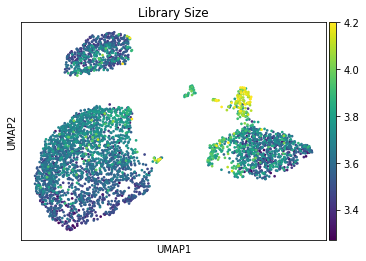

In [108]:
# Displaying UMAP colored by library size
sc.pl.umap(adata, color="Library Size", vmax=4.2)

# 2d.

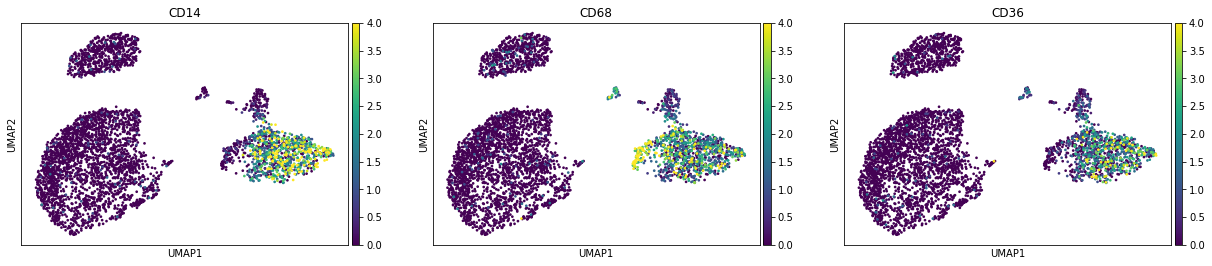

In [129]:
# Monocytes and Macrophages
sc.pl.umap(adata, color=["CD14", "CD68", "CD36"], vmax=4)

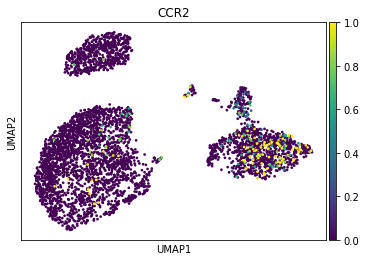

In [130]:
sc.pl.umap(adata, color=["CCR2"], vmax=1)

CD14, CD68, CCR2, CD9 and large library sizes are typically markers of monocytes and macrophages.

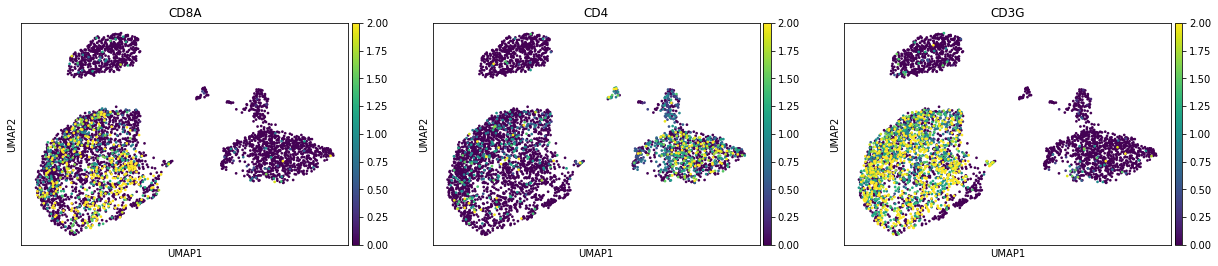

In [112]:
# T-Cells
sc.pl.umap(adata, color=["CD8A", "CD4", "CD3G"], vmax=2)

CD8A, CD4 and CD3G are markers of T-Cells. CD4 is also commonly expressed in monocytes.

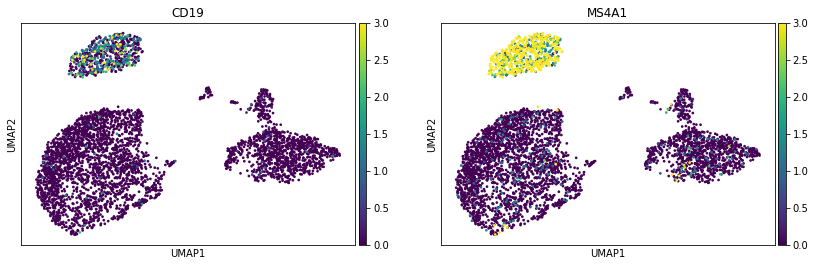

In [131]:
# B-Cells
sc.pl.umap(adata, color=["CD19", "MS4A1"], vmax=3)

CD19 and CD20 (MS4A1 gene) are markers of B-Cells.

# 3.

In [174]:
# Using linear regression to eliminate affect of library size
remove_lib_effect = np.zeros(norm_counts.shape)

for i in range(len(norm_counts)):
    model = stats.linregress(library_sizes, norm_counts[:,i])
    remove_lib_effect[:, i] = norm_counts[:,i] - (model.slope * library_sizes)

array([[ 1.05381147e-02, -2.30946824e-03,  3.82978583e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.52257262e-03, -1.64860063e-03,  1.71247413e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.70444434e-03, -2.12676618e-03,  3.52681142e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.70096179e-02, -5.91926130e-03,  9.81589730e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.53510504e-03, -2.08965482e-03,  3.46526975e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.08018932e-02, -2.36727631e-03,  3.92564882e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

Regularizer is not necessary, as the data is very sparse. When applying the linear regression, you are essential eliminating the majority of counts.

In [169]:
adata2 = ad.AnnData(remove_lib_effect)

adata2.var_names = filtered_genes[1]
adata2.obs_names = filtered_barcodes.values[:,0]

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/sarahmialiu/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


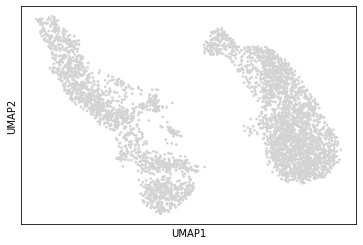

In [170]:
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sc.pl.umap(adata2)